现代贝叶斯主要通过计算机程序来执行，但是还是需要知道基本原理。    
第一章中主要介绍贝叶斯相关概念和方法[原文链接](https://bayesiancomputationbook.com/markdown/chp_01.html)。


## 1.1. 贝叶斯建模
建设模型需要结合领域知识和统计技能。数据是原材料、统计分布是塑造统计模型的主要数据工具。

### 1.1.1 贝叶斯模型
贝叶斯建模的两个特点：   

* 用概率分布描绘未知数值。这些数值称为「参数」；    
* 结合观测数值，通过贝叶斯定理更新参数值。    

贝叶斯建模的三个步骤： 

1. 建模。给定一些数值及这些数值如何被生成的假设，通过随机变量的组合和转换来设计模型；      
2. 推断。结合观测到的数据，基于贝叶斯定理更新我们的模型得到后验分布。这个过程称为**推断**，通过数据来减少不确定性；      
3. 验证。通过数据和领域知识来批判模型。有时需要比较多个模型好坏。      

`第3步验证非常重要！`

### 1.1.2 贝叶斯推断
推断一般指通过证据和理由得出结论贝叶斯推断是统计推断的一种。    
贝叶斯理论给了一种基于$\boldsymbol{Y}$来估计$\theta$的通用框架：    

$$\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}$$

先验分布代表不确定性，通过似然函数(likelihood function)链接观测值和不确定的参数。相乘后得到后验的联合分布。   

![Fig. 1.1](bayesian_triad.png)    

计算后验概率还需要知道归一化常数$p(\boldsymbol{Y})$：    

$${p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}$$    

计算上面的积分常常非常困难，好在一些数值方案可以应对。由于边际似然通常不计算，因此贝叶斯定理经常表示为比例：   

$$\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} \propto \overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}
$$    


错误的数据和模型会导致无意义的结果。我们必须始终对我们的数据、模型和结果保持一定程度的怀疑：    

$$p(\boldsymbol{\theta} \mid  \boldsymbol{Y}, M) \propto  p(\boldsymbol{Y} \mid \boldsymbol{\theta}, M) \; p(\boldsymbol{\theta}, M)
$$    

推断永远基于假设模型$\boldsymbol{M}$。    

## 1.2. 一个DIY采样器，请勿在家里尝试  

归一化常数常不能直接计算，现代贝叶斯推断一般用称为**Universal Inference Engines**的数值方法。    
    
**Universal Inference Engines**有多种算法。应用可能最广泛也最强大的是Markov chain Monte Carlo methods (MCMC)。从很高的视角来看，所有的MCMC方法都是通过抽样来逼近后验分布。后验分布的样本是通过接受或拒绝proposal distribution生成样本而得到的。因此MCMC也称为采样器，它们都能够评估给定参数值的先验和可能性。也就是说，即使我们不知道整个后验是什么样子，我们也可以逐点询问得到密度。    
    
MCMC的一种算法是Metropolis-Hastings。它不是一个非常现代或特别有效的算法，但 Metropolis-Hastings 很容易理解，并且还为理解更复杂和强大的方法提供基础。   
    
Metropolis-Hasting算法：

1. 以$x_i$初始化参数值$\boldsymbol{X}$    
2. 通过proposal distribution $q(x_{i+1} \mid x_i)$从$x_i$产生$x_{i+1}$    
3. 计算接受新值的概率： $$p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \;q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)$$    
4. $R \sim U(0, 1)$，如果$p_a > R$，保存新值，否则保存旧值    
5. 重复2到4的步骤直到生成*足够大*的值样本    


{{< video https://www.youtube.com/watch?v=0lpT-yveuIA >}}    



举一个具体的例子，简单的Beta-Binomial模型：  
  
$$\theta \sim \text{Beta}(\alpha, \beta)$$


$$Y \sim \text{Bin}(n=1, p=\theta)$$    

以上模型有解析解（共轭先验），但是这里我们通过Metropolis-Hastings来计算近：   


In [2]:
from scipy import stats

def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

此随机生成一些假数据做观测数据来进行推断：    


In [3]:
Y = stats.bernoulli(0.7).rvs(20)

之后即可运行Metropolis-Hastings：    


In [4]:
import numpy as np

n_iters = 2000
can_sd = 0.05
α = β =  1
θ = 0.5
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/3034504359.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace["θ"][iter] = θ


以上代码仅是示例，并不高效而且可能因为计算精度产生溢出等问题。同样理论上can_sd并不影响结果，但是实践中它非常重要，会影响方法效率。    
     
现在我们有了 MCMC 示例，我们想要了解它是什么样的。检查贝叶斯推理结果的常见方法是将每次迭代的采样值与直方图或其他可视化工具一起绘制以表示分布：    

[]

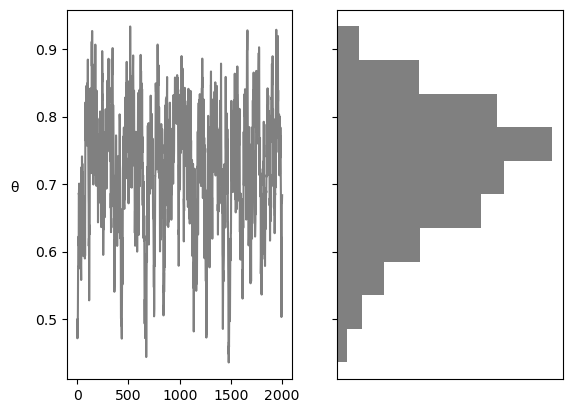

In [5]:
import matplotlib.pyplot as plt 

_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'], '0.5')
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], color='0.5', orientation="horizontal", density=True)
axes[1].set_xticks([])

计算一些数值摘要也很有用： 


In [6]:
import arviz as az

az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.72,0.09,0.55,0.89


ArviZ函数`summary`计算了均值、标注差和$\theta$的94%最高密度区间（HDI）   
也可以通过`az.plot_posterior(trace)`得到类似的结果。图通过**kernel density estimator (KDE)**计算生成。    


<Axes: title={'center': 'θ'}>

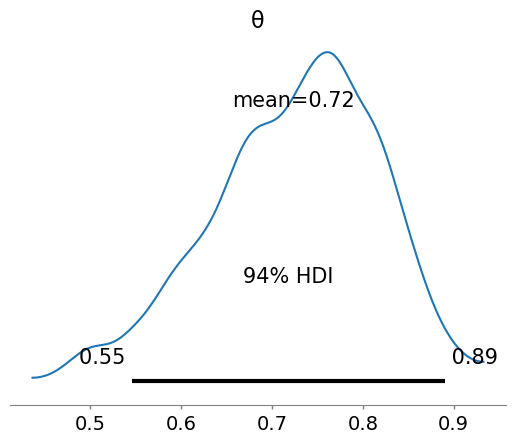

In [7]:
az.plot_posterior(trace)

HDI一般选择50%或95%水平，但是ArviZ选择94%。这样的原因是94%跟95%差不多，而且提醒用户95%没什么特别之处。   

## 1.3. 要自动推断，不要自动建模
我们应该拥抱 **Probabilistic Programming Languages (PPL)** 但不是用`scipy.stats`自己造轮子。    
有很多工具允许用户贝叶斯建模，并且自动化执行贝叶斯推断。不幸的是Universal Inference Engines并不是真正的universal。现代贝叶斯实践者需要理解并解决这些限制。    
    
本书中将使用PyMC和TensorFlow Probability。让我们用PyMC对上面的例子建模：


In [8]:
import pymc as pm

# Declare a model in PyMC
with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

    # Sample from the posterior distribution
    idata = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


以上代码写起来更加简洁，并且可以通过`pm.model_to_graphviz(model)`对模型进行可视化。


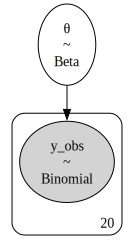

In [9]:
pm.model_to_graphviz(model)

Probabilistic Programming Language不仅能计算后验分布，而且可以模拟各种分布    


In [10]:
pred_dists = (pm.sample_prior_predictive(2000, model).prior_predictive.y_obs.to_numpy()[0],
              pm.sample_posterior_predictive(idata, predictions=True, model = model).predictions.y_obs.to_numpy()[0])

Sampling: [y_obs, θ]


Sampling: [y_obs]


Text(0.5, 0, 'θ')

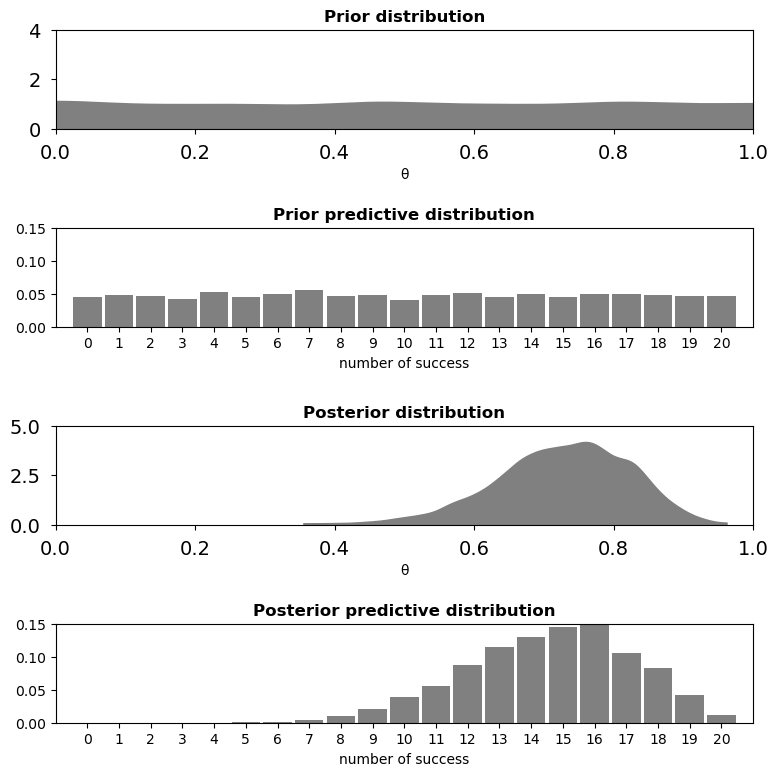

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

plt.subplots_adjust(hspace=1) 

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(1), hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                                           ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution",fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(θ, 1000), plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("θ")

az.plot_dist(idata.posterior["θ"], plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("θ")

In [12]:
with model:
    y_obs_test = pm.Binomial("y_obs_new", n=1, p=idata.posterior["θ"].mean().item(), observed=Y)
    
temp = pm.draw(y_obs_test, 2000)

值得注意的是，后验预测分布依然保留了先验的不确定性，所以对比以后验参数预测均值做参数值产生的预测分布，它会更宽。

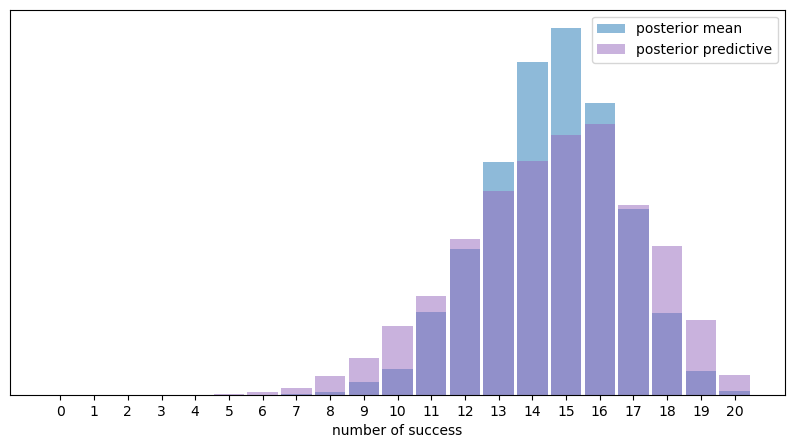

In [13]:
predictions = (temp, pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

## 1.4. 先验的几种选择

必须选择先验分布既是一种负担也是一种福利。从业者了解模型假设并能够灵活地改变它们是有优势的。先验只是假设的一种形式。    
    
本节讨论几种选择先验分布的常见方法，信息梯度（*nformativeness gradient*）从不包含任何信息的“白板”到包含尽可能多的信息的高信息量。

### 1.4.1. 共轭先验

如果后验分布与先验分布属于同一分布族，则先验与似然共轭。例如似然是泊松分布，先验是伽马分布，那么后验也是伽马分布。    
     
共轭先验在数学上很方便，不需要复杂的计算，可通过笔和纸完成。现代一般有更好的选择，因为计算几乎允许使用任何先验进行推理，不仅仅包含共轭先验。
但是在学习中和特定场景近实时推断时，它依然很有用。以下对Beta Binomial模型举例：    
    
如上所述，Binomial分布的共轭先验是Beta分布。我们可以通过以下方式计算后验分布：

$$
p(\theta \mid Y) \propto \overbrace{\frac{N!}{y!(N-y)!} \theta^y (1 - \theta)^{N-y}}^{\text{binomial-likelihood}} \: \overbrace{\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, \theta^{\alpha-1}(1-\theta)^{\beta-1}}^{\text{beta.prior}}
$$

由于不包含$\theta$的项都是常数，因此可以简化为：

$$
p(\theta \mid Y) \propto \overbrace{\theta^y (1 - \theta)^{N-y}}^{\text{binomial-likelihood}} \: \overbrace{ \theta^{\alpha-1}(1-\theta)^{\beta-1}}^{\text{beta.prior}}
$$    

整理后：

$$
p(\theta \mid Y) \propto \theta^{\alpha-1+y}(1-\theta)^{\beta-1+N-y}
$$

后验分布依然是有效分布，需要添加归一化常数来保证pdf的积分为1。由于上述公式看起来是Beta分布公式里的一部分，因此容易得到后验分布为：

$$
p(\theta \mid Y) \propto \frac{\Gamma(\alpha_{post}+\beta_{post})}{\Gamma(\alpha_{post})\Gamma(\beta_{post})} \theta^{\alpha_{post}-1}(1-\theta)^{\beta_{post}-1} = \text{Beta}(\alpha_{post}, \beta_{post})
$$

其中$\alpha_{post} = \alpha + y$，$\beta_{post} = \beta + N - y$    
    
因为 Beta-Binomial 模型的后验为Beta分布，所以我们可以基于后验分布继续进行推断。这意味着如果我们一次更新前一个数据点或者一次使用整个数据集，我们将得到相同的结果。    
例如下面的例子：


/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/4213617618.py:22: RuntimeWarning: invalid value encountered in divide
  axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)


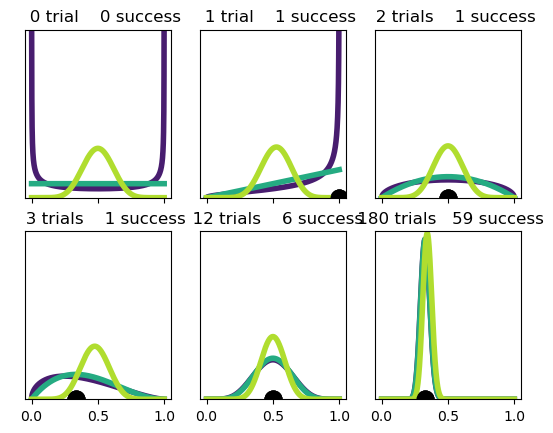

In [21]:
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

_, axes = plt.subplots(2,3, sharey=True, sharex=True)
axes = np.ravel(axes)

n_trials = [0, 1, 2, 3, 12, 180]
success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, success)

beta_params = [(0.5, 0.5), (1, 1), (10, 10)]
θ = np.linspace(0, 1, 1500)
for idx, (N, y) in enumerate(data):
    s_n = ("s" if (N > 1) else "")
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_theta_given_y = stats.beta.pdf(θ, a_prior + y, b_prior + N - y)

        axes[idx].plot(θ, p_theta_given_y, lw=4, color=viridish[jdx])
        axes[idx].set_yticks([])
        axes[idx].set_ylim(0, 12)
        axes[idx].plot(np.divide(y, N), 0, color="k", marker="o", ms=12)
        axes[idx].set_title(f"{N:4d} trial{s_n} {y:4d} success")

先验的期望为：

$$
\mathbb{E}[\theta]  = \frac{\alpha}{\alpha + \beta}
$$

后验的期望为：

$$
\mathbb{E}[\theta \mid Y]  = \frac{\alpha + y}{\alpha + \beta + N}
$$

从上可知，当$n \rightarrow \infty$，期望会趋向于$\hat \theta = \frac{y}{n}$    
    
后验分布众数：

$$
\operatorname*{argmax}_{\theta}{[\theta \mid Y]}  = \frac{\alpha + y - 1}{\alpha + \beta + n - 2}
$$

后验众数常称为**maximum a posterior**（MAP）。

### 1.4.2. 客观先验

当没有先验知识时，遵循*principle of indifference*听起来是合理的。在贝叶斯统计的背景下，这一原理推动了客观先验（**objective priors**）的研究和使用。这些方法尽量减少对先验对分析结果的影响，即消除“主观性“。当然这并没有消除其他主观性，比如似然函数、数据选择过程、建模选择等等。    

客观先验的一种方法是Jeffreys’ prior (JP)。Jeffreys' prior（JP）具有在重新参数化下不变的特性，即，以不同但数学上等价的方式写出表达式。   
举例说明：Alice有一个binomial likelihood包含未知参数$\theta$，她选择了一个先验并计算得到了后验。Bob对同个问题感兴趣但是他需要的结果是**赔率**$\kappa$，即$\kappa = \frac{\theta}{1 - \theta}$。他有两种选择：基于Alice的后验结果$\theta$计算$\kappa$，或者对$\kappa$选择一个先验分布来计算后验。如果使用了JPs，则无论Bob选择哪种方式，他会得到相同的结果。     
    
一维情况下：

$$p(\theta) \propto \sqrt{I(\theta)}$$

其中$I(\theta)$是费希尔信息的期望：

$$I(\theta) = - \mathbb{E_{Y}}\left[\frac{d^2}{d\theta^2} \log p(Y \mid \theta)\right]$$

因此似然函数$p(Y \mid \theta)$选好后，JP就已经确定。   

          
回到上述例子，对Alice来说JP为：

$$p(\theta) \propto \theta^{-0.5} (1-\theta)^{-0.5}$$    

对Bob来说JP为：

$$p(\kappa) \propto \kappa^{-0.5} (1 + \kappa)^{-1}$$    


/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/1380693406.py:2: RuntimeWarning: divide by zero encountered in divide
  κ = (θ / (1-θ))
/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/1380693406.py:10: RuntimeWarning: divide by zero encountered in power
  axes[0, 0].plot(θ, θ**(-0.5) * (1-θ)**(-0.5))
/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/1380693406.py:15: RuntimeWarning: divide by zero encountered in power
  axes[0, 1].plot(κ, κ**(-0.5) * (1 + κ)**(-1))
/var/folders/mf/vz25j9w14ng0kgrg7jz5tc7w0000gn/T/ipykernel_51324/1380693406.py:17: RuntimeWarning: invalid value encountered in multiply
  axes[1, 1].plot(κ, κ**(y-0.5) * (1 + κ)**(-n-1))


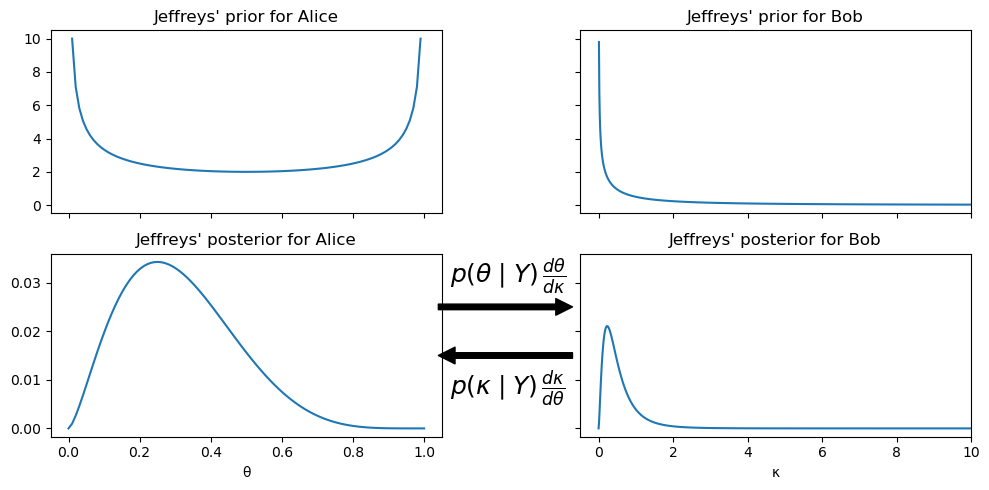

In [17]:
θ = np.linspace(0, 1, 100)
κ = (θ / (1-θ))
y = 2
n = 7

_, axes = plt.subplots(2, 2, figsize=(10, 5),
                     sharex='col', sharey='row', constrained_layout=False)

axes[0, 0].set_title("Jeffreys' prior for Alice")
axes[0, 0].plot(θ, θ**(-0.5) * (1-θ)**(-0.5))
axes[1, 0].set_title("Jeffreys' posterior for Alice")
axes[1, 0].plot(θ, θ**(y-0.5) * (1-θ)**(n-y-0.5))
axes[1, 0].set_xlabel("θ")
axes[0, 1].set_title("Jeffreys' prior for Bob")
axes[0, 1].plot(κ, κ**(-0.5) * (1 + κ)**(-1))
axes[1, 1].set_title("Jeffreys' posterior for Bob")
axes[1, 1].plot(κ, κ**(y-0.5) * (1 + κ)**(-n-1))
axes[1, 1].set_xlim(-0.5, 10)
axes[1, 1].set_xlabel("κ")
axes[1, 1].text(-4.0, 0.030, size=18, s=r'$p(\theta \mid Y) \, \frac{d\theta}{d\kappa}$')
axes[1, 1].annotate("", xy=(-0.5, 0.025), xytext=(-4.5, 0.025),
                  arrowprops=dict(facecolor='black', shrink=0.05))
axes[1, 1].text(-4.0, 0.007, size=18, s= r'$p(\kappa \mid Y) \, \frac{d\kappa}{d\theta}$')
axes[1, 1].annotate("", xy=(-4.5, 0.015), xytext=(-0.5, 0.015),
                  arrowprops=dict(facecolor='black', shrink=0.05),
                  annotation_clip=False)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()

JP 可能是Improper prior，这意味着它的积分可能不为 1。    
    
JPs不是唯一的客观先验方法。比如另一种Bernardo reference priors通过最大化先验与后验的Kullback-Leibler divergence期望来选择。

### 1.4.3. 最大熵先验

证明先验选择合理性的另一种方法是选择具有最高熵的先验。    
为了得到最大熵先验，我们需要在约束条件下解决最优化问题。数学上称为拉格朗日乘子法。

Text(0, 0.5, '$p(t)$')

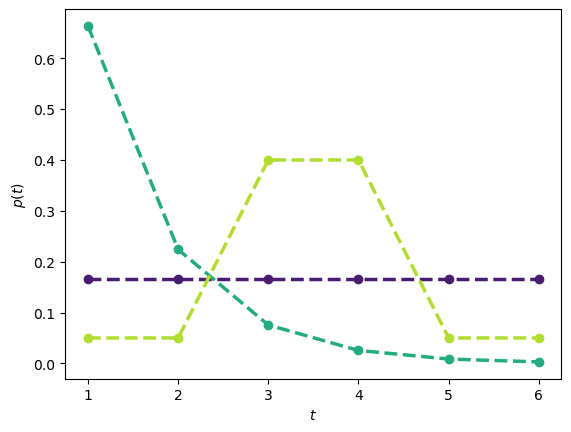

In [22]:
from scipy.optimize import minimize
from scipy.stats import entropy

cons = [[{"type": "eq", "fun": lambda x: np.sum(x) - 1}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: 1.5 - np.sum(x * np.arange(1, 7))}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: np.sum(x[[2, 3]]) - 0.8}]]

max_ent = []
for i, c in enumerate(cons):
    val = minimize(lambda x: -entropy(x), x0=[1/6]*6, bounds=[(0., 1.)] * 6,
                   constraints=c)['x']
    max_ent.append(entropy(val))
    plt.plot(np.arange(1, 7), val, 'o--', color=viridish[i], lw=2.5)
plt.xlabel("$t$")
plt.ylabel("$p(t)$")

上图是通过最大熵得到的三种分布。紫色分布无约束，它是一个均匀分布；青色分布增加了约束条件，它的均值为1.5，得到了一个类指数分布；最后一个约束条件为已知3和4的出现概率为0.8。   
可以将最大熵理解为对未知分配均等概率的过程。无约束时均匀分布；已知3和4合计出现概率时，对3和4均等分配概率，其它也均等分配概率；类指数分布虽然看起来不均匀，但是已经是此约束下最均匀的分配方式。

In [23]:
ite = 100_000
entropies = np.zeros((3, ite))
for idx in range(ite):
    rnds = np.zeros(6)
    total = 0
    x_ = np.random.choice(np.arange(1, 7), size=6, replace=False)
    for i in x_[:-1]:
        rnd = np.random.uniform(0, 1-total)
        rnds[i-1] = rnd
        total = rnds.sum()
    rnds[-1] = 1 - rnds[:-1].sum()
    H = entropy(rnds)
    entropies[0, idx] = H
    if abs(1.5 - np.sum(rnds * x_)) < 0.01:
        entropies[1, idx] = H
    prob_34 = sum(rnds[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8 - prob_34) < 0.01:
        entropies[2, idx] = H

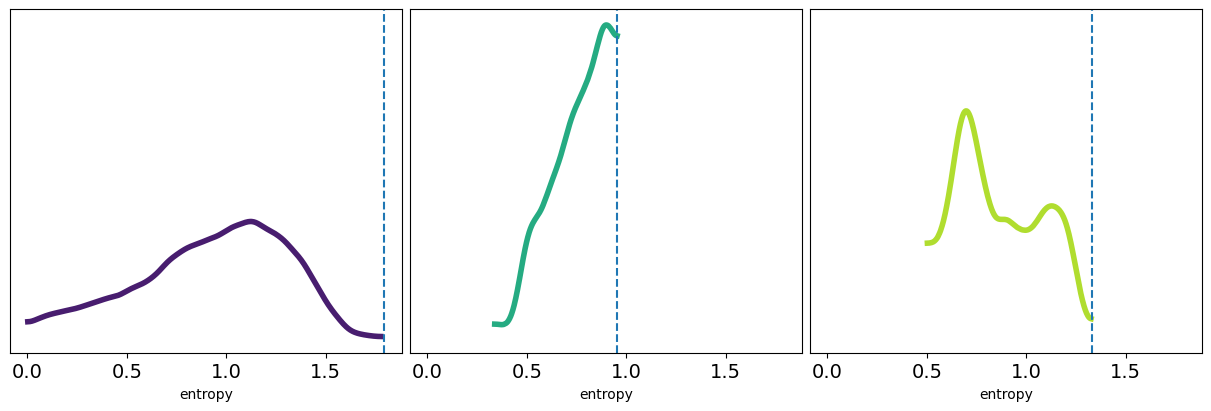

In [24]:
_, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)

for i in range(3):
    az.plot_kde(entropies[i][np.nonzero(entropies[i])], ax=ax[i], plot_kwargs={"color":viridish[i], "lw":4})
    ax[i].axvline(max_ent[i], 0, 1, ls="--")
    ax[i].set_yticks([])
    ax[i].set_xlabel("entropy")

上图是同一份样本下三个分布的熵。看起来没有一个随机生成的分布的熵大于具有最大熵的分布。    
    
一些约束下的最大熵分布：

- 无约束：均匀分布
- 范围 $[0, \infty)$，均值为正：指数分布
- 范围 $(-\infty, \infty)$，且约束条件为均值绝对偏差（即所有观察值与均值的绝对差的平均值）为定值：拉普拉斯分布（也被称为双指数分布）
- 范围 $(-\infty, \infty)$，已知均值和方差：正态分布
- 范围 $[-\pi, \pi]$，已知均值和方差：Von Mises
- 只有两种无序的结果和一个常数均值：二项分布，或者如果我们有稀有事件，则使用泊松分布（泊松分布可以被视为二项分布的一个特殊情况）

### 1.4.4. 弱信息先验和正则化先验

上面使用通用程序生成模糊的、无信息的先验，旨在不将太多信息放入我们的分析中。这些生成先验的过程还提供了一种“以某种方式”自动生成先验的方法。   
在本书中我们不会过多依赖这些先验。先验启发（与其他建模决策一样）应该依赖于上下文，这意味着特定问题的细节甚至给定科学领域的特质可以影响我们对先验的选择。    
    
弱信息先验的构成通常不像 JP 或 MaxEnt 那样在数学上得到明确的定义。它们更加注重实证和模型驱动，是通过领域专业知识和模型本身组合定义的。

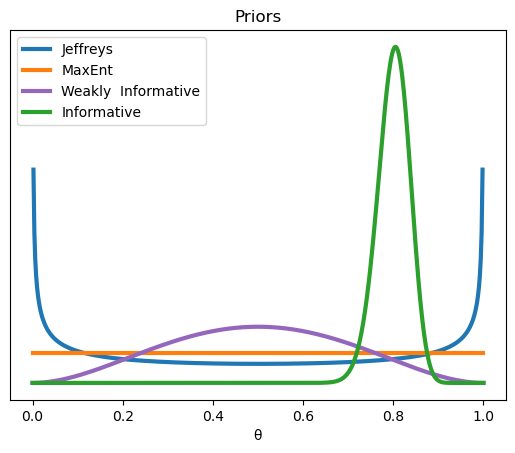

In [25]:
x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys", "MaxEnt", "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = stats.beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()

上图是对Beta-Binomial例子的四种先验。前两种是JP和MaxEnt；第三种是弱信息先验，偏好于0.5但是不确定性还是很高；最后一个是信息丰富的先验，主要围绕0.8附近。如果我们从理论、先前的实验、观察数据等中获得了高质量的信息，那么使用信息先验是一个有效的选择，但是“非凡的主张需要非凡的证据”.    
    
由于弱信息先验可以将后验分布保持在一定的合理范围内，因此它们也称为正则化先验。正则化是一种添加信息的过程，目的是解决不适定问题或减少过度拟合的机会，而先验提供了执行正则化的原则方法。在本书中通常会使用弱信息先验。    

### 1.4.5. 使用先验预测分布来评估先验    

先验预测分布是个方便的工具，从观测值思考比从模型参数思考更容易。计算先前的预测可以帮助我们确保我们的模型已正确编写，并且能够在我们的概率编程语言中运行，甚至可以帮助我们调试我们的模型。

## 1.5. 练习
待完善